# Reformat final dataset

Purpose of this notebook is to re-format the final ECG and EDA datasets from long into wide format

## Imports

In [1]:
# fmt: off
import os
from pathlib import Path
import numpy as np
import pandas as pd
# fmt: on

## Parameters

In [2]:
DATA_DIR = Path().cwd().parent / "data"
FINAL_DATA_DIR = DATA_DIR / "final"
BEHAVIORAL_DATA_DIR = DATA_DIR / "behavioral"

## Support Functions

In [3]:
def prettify_pivot_colnames(df: pd.DataFrame) -> pd.DataFrame:
    df.columns = [
        f"{var}_{segment}" for var, segment in df.columns
    ]
    return df


def map_segment_story_code(row: pd.Series) -> str:
    if row["segment_name"] == "Story 1":
        return row["STORY1NAME"]
    elif row["segment_name"] == "Story 2":
        return row["STORY2NAME"]
    elif row["segment_name"] == "Story 3":
        return row["STORY3NAME"]
    elif row["segment_name"] == "Story 4":
        return row["STORY4NAME"]
    elif row["segment_name"] == "Story 5":
        return row["STORY5NAME"]
    else:
        return np.nan
    
def map_segment_story_score(row: pd.Series) -> str:
    if row["segment_name"] == "Story 1":
        return np.nan
    elif row["segment_name"] == "Story 2":
        return row["Story2_Score"]
    elif row["segment_name"] == "Story 3":
        return row["Story3_Score"]
    elif row["segment_name"] == "Story 4":
        return row["Story4_Score"]
    elif row["segment_name"] == "Story 5":
        return row["Story5_Score"]
    else:
        return np.nan

# Restructure ECG data

### Load required datasets

In [4]:
extra_df = pd.read_excel(BEHAVIORAL_DATA_DIR / "filtered_data_v3 (with ASAs).xlsx")
print(f"{extra_df.shape = }")
extra_df.head(3)


extra_df.shape = (110, 77)


,ParticipantID,Gender,DOB,Ethnicity,Ethnicity_Other,EduLvl,EduLvl_Other,LTDatingPrtn,LTDatingPrtn_Other,MothEduLvl,...,STORY1NAME,STORY2NAME,STORY3NAME,STORY4NAME,STORY5NAME,Story2_Score,Story3_Score,Story4_Score,Story5_Score,ASA_tot
0,2001,2,2004-05-18 00:00:00,5,,2,,3,,6,...,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,2.20
1,2002,1,2003-05-02 00:00:00,3,,3,,2,,4,...,AS,BH,NITP,SG,SFT,3.3,4.8,3.3,3.0,3.60
2,2003,2,2001-11-09 00:00:00,4,,3,,1,,2,...,AS,SFT,SG,NITP,AC,3.2,4.4,4.0,5.0,4.15


In [5]:
ecg_long_df = pd.read_excel(FINAL_DATA_DIR / "ecg_metrics" / "group_level_blc_ecg_metrics.xlsx").drop(columns = ["Unnamed: 0"])
print(f"{ecg_long_df.shape = }")
ecg_long_df.head(2)


ecg_long_df.shape = (553, 43)


,segment_name,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,...,RSA_Gates_Mean,RSA_Gates_Mean_log,RSA_Gates_SD,usable_analysis_windows_in_segment,RSA_PorgesBohrer_baseline,HRV_SDNN_baseline,heart_rate_bpm_baseline,RSA_PorgesBohrer_corrected,HRV_SDNN_corrected,heart_rate_bpm_corrected
0,Story 1,760.053613,50.901147,NaN,NaN,NaN,NaN,NaN,NaN,41.092865,...,7.890796,2.065697,0.126428,2,-4.677399,77.705814,71.485634,0.202238,-26.804667,7.386317
1,Story 2,797.659660,54.620868,NaN,NaN,NaN,NaN,NaN,NaN,42.066588,...,8.082750,2.089732,0.166900,3,-4.677399,77.705814,71.485634,-0.132016,-23.084947,4.174190


### Re-format column names

In [6]:
story_segment_df = ecg_long_df[["segment_name", "subject_id"]].merge(
    extra_df[["ParticipantID", "STORY1NAME", "STORY2NAME", "STORY3NAME", "STORY4NAME", "STORY5NAME", "Story2_Score", "Story3_Score", "Story4_Score", "Story5_Score"]],
    left_on = ["subject_id"],
    right_on = ["ParticipantID"],
    how = "right"
)
# story_segment_df
story_segment_df.loc[:, "story_order"] = story_segment_df['segment_name']
story_segment_df.loc[:, "story_score"] = story_segment_df.apply(map_segment_story_score, axis=1)
story_segment_df.loc[:, "segment_name"] = story_segment_df.apply(map_segment_story_code, axis=1)
story_segment_df.head(3)

,segment_name,subject_id,ParticipantID,STORY1NAME,STORY2NAME,STORY3NAME,STORY4NAME,STORY5NAME,Story2_Score,Story3_Score,Story4_Score,Story5_Score,story_order,story_score
0,AS,2001.0,2001,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,Story 1,NaN
1,NITP,2001.0,2001,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,Story 2,1.0
2,AC,2001.0,2001,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,Story 3,1.2


In [7]:
cleaned_ecg_long_df = (
    ecg_long_df
    # 
    .merge(story_segment_df[["segment_name", "subject_id", "story_order", "story_score"]], 
           left_on=["segment_name", "subject_id"], 
           right_on=["story_order", "subject_id"],
           how="inner")
    .drop(columns=["segment_name_x"])
    .rename(columns = {"segment_name_y": "story_name"})
)
cleaned_ecg_long_df.head()

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,usable_analysis_windows_in_segment,RSA_PorgesBohrer_baseline,HRV_SDNN_baseline,heart_rate_bpm_baseline,RSA_PorgesBohrer_corrected,HRV_SDNN_corrected,heart_rate_bpm_corrected,story_name,story_order,story_score
0,760.053613,50.901147,NaN,NaN,NaN,NaN,NaN,NaN,41.092865,41.627238,...,2,-4.677399,77.705814,71.485634,0.202238,-26.804667,7.386317,AS,Story 1,NaN
1,797.659660,54.620868,NaN,NaN,NaN,NaN,NaN,NaN,42.066588,42.786720,...,3,-4.677399,77.705814,71.485634,-0.132016,-23.084947,4.174190,NITP,Story 2,3.5
2,775.647368,56.302133,NaN,NaN,NaN,NaN,NaN,NaN,44.986799,45.573612,...,2,-4.677399,77.705814,71.485634,0.188223,-21.403681,5.116204,BH,Story 3,3.5
3,786.806628,43.835340,NaN,NaN,NaN,NaN,NaN,NaN,34.694027,31.776317,...,2,-4.677399,77.705814,71.485634,-0.560891,-33.870474,5.222699,SFT,Story 4,3.0
4,773.166134,64.800184,NaN,NaN,NaN,NaN,NaN,NaN,49.320398,49.947194,...,3,-4.677399,77.705814,71.485634,-0.283975,-12.905630,5.926302,SG,Story 5,3.0


### Pivot

In [8]:
pivot_df = (
    cleaned_ecg_long_df
    .pivot(index = "subject_id", columns=["story_name"], values=[
        "HRV_SDNN_baseline", "HRV_SDNN_corrected", 
        "RSA_PorgesBohrer_baseline", "RSA_PorgesBohrer_corrected",
        "heart_rate_bpm", "heart_rate_bpm_corrected",
        "story_score"])
    )
pivot_df

HRV_SDNN_baseline                                                 \
story_name                AC          AS         BH        NITP         SFT   
subject_id                                                                    
2001              110.276503  110.276503        NaN  110.276503  110.276503   
2002                     NaN   35.396457  35.396457   35.396457   35.396457   
2003               33.171505   33.171505        NaN   33.171505   33.171505   
2004                     NaN   58.808383  58.808383   58.808383   58.808383   
2005               63.445495   63.445495        NaN   63.445495   63.445495   
...                      ...         ...        ...         ...         ...   
2111               55.878944   55.878944        NaN   55.878944   55.878944   
2112               50.036630   50.036630        NaN   50.036630   50.036630   
2113               64.077730   64.077730        NaN   64.077730   64.077730   
2114               31.651238   31.651238        NaN   31.651238   31.651238   
2115               50.748578   50.748578        NaN   50.748578   50.748578   

                       HRV_SDNN_corrected                                   \
story_name          SG                 AC         AS         BH       NITP   
subject_id                                                                   
2001        110.276503         -24.877271 -16.524395        NaN -23.759670   
2002         35.396457                NaN  37.656284  20.256717  14.901276   
2003         33.171505          -7.656123  -7.022546        NaN -12.155730   
2004         58.808383                NaN -19.564398 -13.677832 -21.331035   
2005         63.445495         -26.284187 -19.086072        NaN -29.504245   
...                ...                ...        ...        ...        ...   
2111         55.878944           0.622213  -3.913718        NaN   1.438856   
2112         50.036630          12.034943  -4.014709        NaN  10.074810   
2113         64.077730         -13.898179 -14.561019        NaN  -3.191345   
2114         31.651238           0.487621   1.077443        NaN   2.071620   
2115         50.748578         -14.166835  -7.698062        NaN  -8.177974   

            ... heart_rate_bpm_corrected                                   \
story_name  ...                       BH       NITP        SFT         SG   
subject_id  ...                                                             
2001        ...                      NaN  23.567149  22.765416  14.801957   
2002        ...                13.158159   8.521545  10.056526  11.053254   
2003        ...                      NaN  10.800000  12.356288   9.343644   
2004        ...                13.687147  15.467176  17.209091  17.998836   
2005        ...                      NaN   2.397050  -0.676597   1.791900   
...         ...                      ...        ...        ...        ...   
2111        ...                      NaN   7.125488   6.313719   5.611305   
2112        ...                      NaN   5.903927   6.819595   6.693859   
2113        ...                      NaN   2.790842   5.686580   3.672372   
2114        ...                      NaN  -3.705204  -3.688023  -4.102644   
2115        ...                      NaN   4.734483  10.307842   7.046635   

           story_score                          
story_name          AC  AS   BH NITP  SFT   SG  
subject_id                                      
2001               1.2 NaN  NaN  1.0  1.8  4.8  
2002               NaN NaN  3.3  4.8  3.0  3.3  
2003               5.0 NaN  NaN  4.0  3.2  4.4  
2004               NaN NaN  2.3  2.8  3.0  4.0  
2005               2.0 NaN  NaN  6.0  1.0  1.0  
...                ...  ..  ...  ...  ...  ...  
2111               7.0 NaN  NaN  6.0  5.0  5.0  
2112               3.5 NaN  NaN  1.0  3.0  4.0  
2113               2.5 NaN  NaN  4.5  4.0  3.0  
2114               2.5 NaN  NaN  4.0  5.0  4.0  
2115               5.0 NaN  NaN  5.0  2.5  4.0  

[109 rows x 42 columns]

### Combine AC and BH into ACBH

In [9]:
story_pair = ('AC', 'BH')
new_story = 'ACBH'

# Select only top-level columns (the metrics)
metrics = pivot_df.columns.levels[0]

for metric in metrics:
    if story_pair[0] in pivot_df[metric] or story_pair[1] in pivot_df[metric]:
        pivot_df[(metric, new_story)] = pivot_df[(metric, story_pair[1])].combine_first(
            pivot_df[(metric, story_pair[0])]
        )
        pivot_df = pivot_df.drop(columns=[(metric, story_pair[0]), (metric, story_pair[1])])
pivot_df.head(5)

HRV_SDNN_baseline                                      \
story_name                AS        NITP         SFT          SG   
subject_id                                                         
2001              110.276503  110.276503  110.276503  110.276503   
2002               35.396457   35.396457   35.396457   35.396457   
2003               33.171505   33.171505   33.171505   33.171505   
2004               58.808383   58.808383   58.808383   58.808383   
2005               63.445495   63.445495   63.445495   63.445495   

           HRV_SDNN_corrected                                   \
story_name                 AS       NITP        SFT         SG   
subject_id                                                       
2001               -16.524395 -23.759670 -38.222372 -30.294473   
2002                37.656284  14.901276  16.245960   5.147666   
2003                -7.022546 -12.155730 -14.404401  -9.155870   
2004               -19.564398 -21.331035 -15.396630 -15.473293   
2005               -19.086072 -29.504245  -7.586793 -23.376951   

           RSA_PorgesBohrer_baseline            ... story_score            \
story_name                        AS      NITP  ...        NITP  SFT   SG   
subject_id                                      ...                         
2001                       -4.258989 -4.258989  ...         1.0  1.8  4.8   
2002                       -5.976574 -5.976574  ...         4.8  3.0  3.3   
2003                       -4.966913 -4.966913  ...         4.0  3.2  4.4   
2004                       -5.907845 -5.907845  ...         2.8  3.0  4.0   
2005                       -5.104656 -5.104656  ...         6.0  1.0  1.0   

           HRV_SDNN_baseline HRV_SDNN_corrected RSA_PorgesBohrer_baseline  \
story_name              ACBH               ACBH                      ACBH   
subject_id                                                                  
2001              110.276503         -24.877271                 -4.258989   
2002               35.396457          20.256717                 -5.976574   
2003               33.171505          -7.656123                 -4.966913   
2004               58.808383         -13.677832                 -5.907845   
2005               63.445495         -26.284187                 -5.104656   

           RSA_PorgesBohrer_corrected heart_rate_bpm heart_rate_bpm_corrected  \
story_name                       ACBH           ACBH                     ACBH   
subject_id                                                                      
2001                         0.597830      93.950669                25.218722   
2002                         1.210189      87.069873                13.158159   
2003                        -0.405804      94.944275                 9.744275   
2004                         1.091244      86.887147                13.687147   
2005                        -0.257544      82.604396                 2.004396   

           story_score  
story_name        ACBH  
subject_id              
2001               1.2  
2002               3.3  
2003               5.0  
2004               2.3  
2005               2.0  

[5 rows x 35 columns]

### Prettify colnames

In [10]:
ecg_wide_df = prettify_pivot_colnames(pivot_df)
ecg_wide_df

,HRV_SDNN_baseline_AS,HRV_SDNN_baseline_NITP,HRV_SDNN_baseline_SFT,HRV_SDNN_baseline_SG,HRV_SDNN_corrected_AS,HRV_SDNN_corrected_NITP,HRV_SDNN_corrected_SFT,HRV_SDNN_corrected_SG,RSA_PorgesBohrer_baseline_AS,RSA_PorgesBohrer_baseline_NITP,...,story_score_NITP,story_score_SFT,story_score_SG,HRV_SDNN_baseline_ACBH,HRV_SDNN_corrected_ACBH,RSA_PorgesBohrer_baseline_ACBH,RSA_PorgesBohrer_corrected_ACBH,heart_rate_bpm_ACBH,heart_rate_bpm_corrected_ACBH,story_score_ACBH
subject_id,,,,,,,,,,,,,,,,,,,,,
2001,110.276503,110.276503,110.276503,110.276503,-16.524395,-23.759670,-38.222372,-30.294473,-4.258989,-4.258989,...,1.0,1.8,4.8,110.276503,-24.877271,-4.258989,0.597830,93.950669,25.218722,1.2
2002,35.396457,35.396457,35.396457,35.396457,37.656284,14.901276,16.245960,5.147666,-5.976574,-5.976574,...,4.8,3.0,3.3,35.396457,20.256717,-5.976574,1.210189,87.069873,13.158159,3.3
2003,33.171505,33.171505,33.171505,33.171505,-7.022546,-12.155730,-14.404401,-9.155870,-4.966913,-4.966913,...,4.0,3.2,4.4,33.171505,-7.656123,-4.966913,-0.405804,94.944275,9.744275,5.0
2004,58.808383,58.808383,58.808383,58.808383,-19.564398,-21.331035,-15.396630,-15.473293,-5.907845,-5.907845,...,2.8,3.0,4.0,58.808383,-13.677832,-5.907845,1.091244,86.887147,13.687147,2.3
2005,63.445495,63.445495,63.445495,63.445495,-19.086072,-29.504245,-7.586793,-23.376951,-5.104656,-5.104656,...,6.0,1.0,1.0,63.445495,-26.284187,-5.104656,-0.257544,82.604396,2.004396,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,55.878944,55.878944,55.878944,55.878944,-3.913718,1.438856,15.623045,-7.775004,-4.341936,-4.341936,...,6.0,5.0,5.0,55.878944,0.622213,-4.341936,0.179263,92.072406,5.379202,7.0
2112,50.036630,50.036630,50.036630,50.036630,-4.014709,10.074810,2.113174,9.072605,-4.803878,-4.803878,...,1.0,3.0,4.0,50.036630,12.034943,-4.803878,0.200405,78.544448,4.920887,3.5
2113,64.077730,64.077730,64.077730,64.077730,-14.561019,-3.191345,-9.011278,-13.985742,-5.048033,-5.048033,...,4.5,4.0,3.0,64.077730,-13.898179,-5.048033,-0.848430,79.366282,3.754193,2.5


# Restructure EDA data

In [11]:
extra_df = pd.read_excel(BEHAVIORAL_DATA_DIR / "filtered_data_v3 (with ASAs).xlsx")
print(f"{extra_df.shape = }")
extra_df.head(3)

extra_df.shape = (110, 77)


,ParticipantID,Gender,DOB,Ethnicity,Ethnicity_Other,EduLvl,EduLvl_Other,LTDatingPrtn,LTDatingPrtn_Other,MothEduLvl,...,STORY1NAME,STORY2NAME,STORY3NAME,STORY4NAME,STORY5NAME,Story2_Score,Story3_Score,Story4_Score,Story5_Score,ASA_tot
0,2001,2,2004-05-18 00:00:00,5,,2,,3,,6,...,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,2.20
1,2002,1,2003-05-02 00:00:00,3,,3,,2,,4,...,AS,BH,NITP,SG,SFT,3.3,4.8,3.3,3.0,3.60
2,2003,2,2001-11-09 00:00:00,4,,3,,1,,2,...,AS,SFT,SG,NITP,AC,3.2,4.4,4.0,5.0,4.15


In [12]:
eda_long_df = pd.read_excel(FINAL_DATA_DIR / "eda_features" / "group_level_blc_eda_features.xlsx").drop(columns = ["Unnamed: 0"])
print(f"{eda_long_df.shape = }")
eda_long_df.head(2)


eda_long_df.shape = (509, 28)


,index,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,segment_name,subject_id,segment_length_seconds,...,SCR_Peaks_N_baseline,EDA_Tonic_Mean_baseline,SCR_Peaks_Amplitude_Mean_blc,EDA_Tonic_SD_blc,EDA_Sympathetic_blc,EDA_SympatheticN_blc,EDA_Autocorrelation_blc,SCR_Peaks_N_per_seconds_blc,SCR_Peaks_N_blc,EDA_Tonic_Mean_blc
0,1,1,0.063750,0.123177,NaN,NaN,0.762931,Story 1,2085,56.240,...,0,0.124313,NaN,0.120889,NaN,NaN,-0.183015,0.017781,1,0.234722
1,2,4,0.200623,0.332093,0.001422,0.008131,0.587480,Story 2,2085,76.368,...,0,0.124313,NaN,0.329805,0.001422,0.008123,-0.358466,0.052378,4,1.159836


### Re-format column names

In [13]:
story_segment_df = eda_long_df[["segment_name", "subject_id"]].merge(
    extra_df[["ParticipantID", "STORY1NAME", "STORY2NAME", "STORY3NAME", "STORY4NAME", "STORY5NAME", "Story2_Score", "Story3_Score", "Story4_Score", "Story5_Score"]],
    left_on = ["subject_id"],
    right_on = ["ParticipantID"],
    how = "right"
)
# story_segment_df
story_segment_df.loc[:, "story_order"] = story_segment_df['segment_name']
story_segment_df.loc[:, "story_score"] = story_segment_df.apply(map_segment_story_score, axis=1)
story_segment_df.loc[:, "segment_name"] = story_segment_df.apply(map_segment_story_code, axis=1)
story_segment_df.head(3)

,segment_name,subject_id,ParticipantID,STORY1NAME,STORY2NAME,STORY3NAME,STORY4NAME,STORY5NAME,Story2_Score,Story3_Score,Story4_Score,Story5_Score,story_order,story_score
0,AS,2001.0,2001,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,Story 1,NaN
1,NITP,2001.0,2001,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,Story 2,1.0
2,AC,2001.0,2001,AS,NITP,AC,SFT,SG,1.0,1.2,1.8,4.8,Story 3,1.2


In [14]:
cleaned_eda_long_df = (
    eda_long_df
    # 
    .merge(story_segment_df[["segment_name", "subject_id", "story_order", "story_score"]], 
           left_on=["segment_name", "subject_id"], 
           right_on=["story_order", "subject_id"],
           how="inner")
    .drop(columns=["segment_name_x"])
    .rename(columns = {"segment_name_y": "story_name"})
)
cleaned_eda_long_df.head(10)

,index,SCR_Peaks_N,SCR_Peaks_Amplitude_Mean,EDA_Tonic_SD,EDA_Sympathetic,EDA_SympatheticN,EDA_Autocorrelation,subject_id,segment_length_seconds,SCR_Peaks_N_per_seconds,...,EDA_Tonic_SD_blc,EDA_Sympathetic_blc,EDA_SympatheticN_blc,EDA_Autocorrelation_blc,SCR_Peaks_N_per_seconds_blc,SCR_Peaks_N_blc,EDA_Tonic_Mean_blc,story_name,story_order,story_score
0,1,1,0.063750,0.123177,NaN,NaN,0.762931,2085,56.240,0.017781,...,0.120889,NaN,NaN,-0.183015,0.017781,1,0.234722,AS,Story 1,NaN
1,2,4,0.200623,0.332093,0.001422,0.008131,0.587480,2085,76.368,0.052378,...,0.329805,0.001422,0.008123,-0.358466,0.052378,4,1.159836,NITP,Story 2,3.5
2,3,3,0.256992,0.076234,NaN,NaN,0.036321,2085,58.722,0.051088,...,0.073945,NaN,NaN,-0.909625,0.051088,3,2.249159,BH,Story 3,3.5
3,4,2,0.098387,0.147547,0.000148,0.000045,0.746280,2085,64.608,0.030956,...,0.145258,0.000148,0.000037,-0.199666,0.030956,2,1.960562,SFT,Story 4,3.0
4,5,4,0.237224,0.479976,0.011245,0.003183,0.816302,2085,87.480,0.045725,...,0.477687,0.011245,0.003175,-0.129644,0.045725,4,2.188690,SG,Story 5,3.0
5,1,5,0.835587,0.767780,0.530011,0.002729,0.141169,2071,79.904,0.062575,...,-1.000199,0.511227,-0.004052,-0.735706,0.054038,2,13.448304,AS,Story 1,NaN
6,2,5,0.804635,0.450014,0.218200,0.001014,0.097113,2071,78.460,0.063727,...,-1.317966,0.199416,-0.005767,-0.779762,0.055189,2,14.357971,SFT,Story 2,4.0
7,3,3,0.522342,0.932412,0.326212,0.001278,0.536913,2071,79.182,0.037887,...,-0.835568,0.307428,-0.005503,-0.339962,0.029350,0,14.322688,SG,Story 3,3.0
8,4,3,0.592262,1.192780,0.492327,0.002743,0.460063,2071,125.864,0.023835,...,-0.575200,0.473543,-0.004038,-0.416812,0.015298,0,12.634837,NITP,Story 4,5.0
9,5,3,0.782495,0.983893,0.244314,0.000782,0.548584,2071,77.510,0.038705,...,-0.784087,0.225531,-0.005999,-0.328292,0.030167,0,13.413980,AC,Story 5,5.5


### Pivot

In [15]:
pivot_df = (
    cleaned_eda_long_df
    .pivot(index = "subject_id", columns=["story_name"], values=[
        "EDA_Tonic_Mean_baseline", "EDA_Tonic_Mean_blc", 
        "SCR_Peaks_N_per_seconds_baseline", "SCR_Peaks_N_per_seconds_blc", 
        "SCR_Peaks_Amplitude_Mean_baseline", "SCR_Peaks_Amplitude_Mean_blc", "story_score"])
    )
pivot_df

EDA_Tonic_Mean_baseline                                   \
story_name                      AC         AS         BH       NITP   
subject_id                                                            
2001                     14.913535  14.913535        NaN  14.913535   
2002                           NaN   7.403002   7.403002   7.403002   
2003                     15.960911  15.960911        NaN  15.960911   
2004                           NaN  17.821375  17.821375  17.821375   
2005                     11.021737  11.021737        NaN  11.021737   
...                            ...        ...        ...        ...   
2111                      9.780467   9.780467        NaN   9.780467   
2112                      8.147547   8.147547        NaN   8.147547   
2113                      8.873344   8.873344        NaN   8.873344   
2114                      0.510154   0.510154        NaN   0.510154   
2115                      0.930459   0.930459        NaN   0.930459   

                                 EDA_Tonic_Mean_blc                      \
story_name        SFT         SG                 AC        AS        BH   
subject_id                                                                
2001        14.913535  14.913535           4.133050  7.537036       NaN   
2002         7.403002   7.403002                NaN  5.369389  6.113454   
2003        15.960911  15.960911           1.224980  4.176782       NaN   
2004        17.821375  17.821375                NaN  8.188937  4.884707   
2005        11.021737  11.021737           9.396294  9.368585       NaN   
...               ...        ...                ...       ...       ...   
2111         9.780467   9.780467           2.820609  4.420316       NaN   
2112         8.147547   8.147547           6.066085  6.202942       NaN   
2113         8.873344   8.873344           1.968473  3.290808       NaN   
2114         0.510154   0.510154           7.193035  8.624130       NaN   
2115         0.930459   0.930459           0.800486  3.064508       NaN   

                      ... SCR_Peaks_Amplitude_Mean_blc                      \
story_name      NITP  ...                           BH      NITP       SFT   
subject_id            ...                                                    
2001        5.447946  ...                          NaN  0.155894  0.245169   
2002        5.657731  ...                          NaN       NaN       NaN   
2003        1.299974  ...                          NaN  0.572168  0.575041   
2004        3.976671  ...                          NaN  0.098620       NaN   
2005        7.414727  ...                          NaN -0.102043 -0.188983   
...              ...  ...                          ...       ...       ...   
2111        2.602551  ...                          NaN  0.084909  0.031065   
2112        5.926480  ...                          NaN  0.140177  0.106204   
2113        1.714970  ...                          NaN -0.254066  0.022831   
2114        8.151690  ...                          NaN       NaN       NaN   
2115        1.022150  ...                          NaN       NaN       NaN   

                     story_score                          
story_name        SG          AC  AS   BH NITP  SFT   SG  
subject_id                                                
2001        0.304674         1.2 NaN  NaN  1.0  1.8  4.8  
2002             NaN         NaN NaN  3.3  4.8  3.0  3.3  
2003        0.711825         5.0 NaN  NaN  4.0  3.2  4.4  
2004             NaN         NaN NaN  2.3  2.8  3.0  4.0  
2005       -0.494469         2.0 NaN  NaN  6.0  1.0  1.0  
...              ...         ...  ..  ...  ...  ...  ...  
2111        0.000977         7.0 NaN  NaN  6.0  5.0  5.0  
2112        0.073782         3.5 NaN  NaN  1.0  3.0  4.0  
2113       -0.069931         2.5 NaN  NaN  4.5  4.0  3.0  
2114             NaN         2.5 NaN  NaN  4.0  5.0  4.0  
2115             NaN         5.0 NaN  NaN  5.0  2.5  4.0  

[101 rows x 42 columns]

### Combine AC and BH into ACBH

In [16]:
story_pair = ('AC', 'BH')
new_story = 'ACBH'

# Select only top-level columns (the metrics)
metrics = pivot_df.columns.levels[0]

for metric in metrics:
    if story_pair[0] in pivot_df[metric] or story_pair[1] in pivot_df[metric]:
        pivot_df[(metric, new_story)] = pivot_df[(metric, story_pair[1])].combine_first(
            pivot_df[(metric, story_pair[0])]
        )
        pivot_df = pivot_df.drop(columns=[(metric, story_pair[0]), (metric, story_pair[1])])
pivot_df.head(5)

EDA_Tonic_Mean_baseline                                   \
story_name                      AS       NITP        SFT         SG   
subject_id                                                            
2001                     14.913535  14.913535  14.913535  14.913535   
2002                      7.403002   7.403002   7.403002   7.403002   
2003                     15.960911  15.960911  15.960911  15.960911   
2004                     17.821375  17.821375  17.821375  17.821375   
2005                     11.021737  11.021737  11.021737  11.021737   

           EDA_Tonic_Mean_blc                                \
story_name                 AS      NITP       SFT        SG   
subject_id                                                    
2001                 7.537036  5.447946  4.522062  2.713935   
2002                 5.369389  5.657731  5.401066  5.769490   
2003                 4.176782  1.299974  3.831195  2.297783   
2004                 8.188937  3.976671  5.778207  7.442184   
2005                 9.368585  7.414727  8.725685  7.157574   

           SCR_Peaks_N_per_seconds_baseline            ... story_score       \
story_name                               AS      NITP  ...        NITP  SFT   
subject_id                                             ...                    
2001                               0.015088  0.015088  ...         1.0  1.8   
2002                               0.000000  0.000000  ...         4.8  3.0   
2003                               0.003333  0.003333  ...         4.0  3.2   
2004                               0.003333  0.003333  ...         2.8  3.0   
2005                               0.030000  0.030000  ...         6.0  1.0   

                EDA_Tonic_Mean_baseline EDA_Tonic_Mean_blc  \
story_name   SG                    ACBH               ACBH   
subject_id                                                   
2001        4.8               14.913535           4.133050   
2002        3.3                7.403002           6.113454   
2003        4.4               15.960911           1.224980   
2004        4.0               17.821375           4.884707   
2005        1.0               11.021737           9.396294   

           SCR_Peaks_N_per_seconds_baseline SCR_Peaks_N_per_seconds_blc  \
story_name                             ACBH                        ACBH   
subject_id                                                                
2001                               0.015088                    0.045369   
2002                               0.000000                    0.017108   
2003                               0.003333                    0.053264   
2004                               0.003333                   -0.003333   
2005                               0.030000                    0.036028   

           SCR_Peaks_Amplitude_Mean_baseline SCR_Peaks_Amplitude_Mean_blc  \
story_name                              ACBH                         ACBH   
subject_id                                                                  
2001                                0.336048                     0.358343   
2002                                     NaN                          NaN   
2003                                0.261509                     0.344005   
2004                                0.602191                          NaN   
2005                                0.653558                    -0.073519   

           story_score  
story_name        ACBH  
subject_id              
2001               1.2  
2002               3.3  
2003               5.0  
2004               2.3  
2005               2.0  

[5 rows x 35 columns]

### Prettify colnames

In [17]:
eda_wide_df = prettify_pivot_colnames(pivot_df)
eda_wide_df

,EDA_Tonic_Mean_baseline_AS,EDA_Tonic_Mean_baseline_NITP,EDA_Tonic_Mean_baseline_SFT,EDA_Tonic_Mean_baseline_SG,EDA_Tonic_Mean_blc_AS,EDA_Tonic_Mean_blc_NITP,EDA_Tonic_Mean_blc_SFT,EDA_Tonic_Mean_blc_SG,SCR_Peaks_N_per_seconds_baseline_AS,SCR_Peaks_N_per_seconds_baseline_NITP,...,story_score_NITP,story_score_SFT,story_score_SG,EDA_Tonic_Mean_baseline_ACBH,EDA_Tonic_Mean_blc_ACBH,SCR_Peaks_N_per_seconds_baseline_ACBH,SCR_Peaks_N_per_seconds_blc_ACBH,SCR_Peaks_Amplitude_Mean_baseline_ACBH,SCR_Peaks_Amplitude_Mean_blc_ACBH,story_score_ACBH
subject_id,,,,,,,,,,,,,,,,,,,,,
2001,14.913535,14.913535,14.913535,14.913535,7.537036,5.447946,4.522062,2.713935,0.015088,0.015088,...,1.0,1.8,4.8,14.913535,4.133050,0.015088,0.045369,0.336048,0.358343,1.2
2002,7.403002,7.403002,7.403002,7.403002,5.369389,5.657731,5.401066,5.769490,0.000000,0.000000,...,4.8,3.0,3.3,7.403002,6.113454,0.000000,0.017108,NaN,NaN,3.3
2003,15.960911,15.960911,15.960911,15.960911,4.176782,1.299974,3.831195,2.297783,0.003333,0.003333,...,4.0,3.2,4.4,15.960911,1.224980,0.003333,0.053264,0.261509,0.344005,5.0
2004,17.821375,17.821375,17.821375,17.821375,8.188937,3.976671,5.778207,7.442184,0.003333,0.003333,...,2.8,3.0,4.0,17.821375,4.884707,0.003333,-0.003333,0.602191,NaN,2.3
2005,11.021737,11.021737,11.021737,11.021737,9.368585,7.414727,8.725685,7.157574,0.030000,0.030000,...,6.0,1.0,1.0,11.021737,9.396294,0.030000,0.036028,0.653558,-0.073519,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,9.780467,9.780467,9.780467,9.780467,4.420316,2.602551,3.374431,2.937567,0.049681,0.049681,...,6.0,5.0,5.0,9.780467,2.820609,0.049681,0.002468,0.566435,0.157549,7.0
2112,8.147547,8.147547,8.147547,8.147547,6.202942,5.926480,5.964973,6.251782,0.022372,0.022372,...,1.0,3.0,4.0,8.147547,6.066085,0.022372,0.120584,0.378339,0.034350,3.5
2113,8.873344,8.873344,8.873344,8.873344,3.290808,1.714970,2.649957,2.295993,0.051857,0.051857,...,4.5,4.0,3.0,8.873344,1.968473,0.051857,0.012043,0.685900,-0.110800,2.5


# Merge pivotted data with behavioral extra data

In [18]:
final_df = (
    extra_df
    .merge(ecg_wide_df, left_on = "ParticipantID", right_on = "subject_id", how = "left")
    .merge(eda_wide_df.drop(columns = ['story_score_AS','story_score_NITP', 'story_score_SFT', 'story_score_SG', "story_score_ACBH"]), left_on = "ParticipantID", right_on = "subject_id", how = "left")
)

final_df

,ParticipantID,Gender,DOB,Ethnicity,Ethnicity_Other,EduLvl,EduLvl_Other,LTDatingPrtn,LTDatingPrtn_Other,MothEduLvl,...,SCR_Peaks_Amplitude_Mean_blc_AS,SCR_Peaks_Amplitude_Mean_blc_NITP,SCR_Peaks_Amplitude_Mean_blc_SFT,SCR_Peaks_Amplitude_Mean_blc_SG,EDA_Tonic_Mean_baseline_ACBH,EDA_Tonic_Mean_blc_ACBH,SCR_Peaks_N_per_seconds_baseline_ACBH,SCR_Peaks_N_per_seconds_blc_ACBH,SCR_Peaks_Amplitude_Mean_baseline_ACBH,SCR_Peaks_Amplitude_Mean_blc_ACBH
0,2001,2,2004-05-18 00:00:00,5,,2,,3,,6,...,0.212414,0.155894,0.245169,0.304674,14.913535,4.133050,0.015088,0.045369,0.336048,0.358343
1,2002,1,2003-05-02 00:00:00,3,,3,,2,,4,...,NaN,NaN,NaN,NaN,7.403002,6.113454,0.000000,0.017108,NaN,NaN
2,2003,2,2001-11-09 00:00:00,4,,3,,1,,2,...,0.410604,0.572168,0.575041,0.711825,15.960911,1.224980,0.003333,0.053264,0.261509,0.344005
3,2004,1,2001-05-07 00:00:00,1,,4,,4,,4,...,NaN,0.098620,NaN,NaN,17.821375,4.884707,0.003333,-0.003333,0.602191,NaN
4,2005,2,2002-07-03 00:00:00,4,,2,,2,,4,...,-0.238409,-0.102043,-0.188983,-0.494469,11.021737,9.396294,0.030000,0.036028,0.653558,-0.073519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2111,2,2003-09-06 00:00:00,6,,3,,1,,4,...,0.041442,0.084909,0.031065,0.000977,9.780467,2.820609,0.049681,0.002468,0.566435,0.157549
106,2112,2,2003-12-23 00:00:00,4,,3,,3,,3,...,-0.103652,0.140177,0.106204,0.073782,8.147547,6.066085,0.022372,0.120584,0.378339,0.034350
107,2113,2,2004-08-30 00:00:00,6,,3,,1,,3,...,-0.205515,-0.254066,0.022831,-0.069931,8.873344,1.968473,0.051857,0.012043,0.685900,-0.110800
108,2114,2,2003-09-28 00:00:00,5,,3,,1,,4,...,NaN,NaN,NaN,NaN,0.510154,7.193035,0.000000,0.041838,NaN,NaN


# Sanity checks

array([[<Axes: title={'center': 'HRV_SDNN_baseline'}>,
        <Axes: title={'center': 'HRV_SDNN_corrected'}>],
       [<Axes: title={'center': 'RSA_PorgesBohrer_baseline'}>,
        <Axes: title={'center': 'RSA_PorgesBohrer_corrected'}>],
       [<Axes: title={'center': 'heart_rate_bpm'}>,
        <Axes: title={'center': 'heart_rate_bpm_corrected'}>]],
      dtype=object)

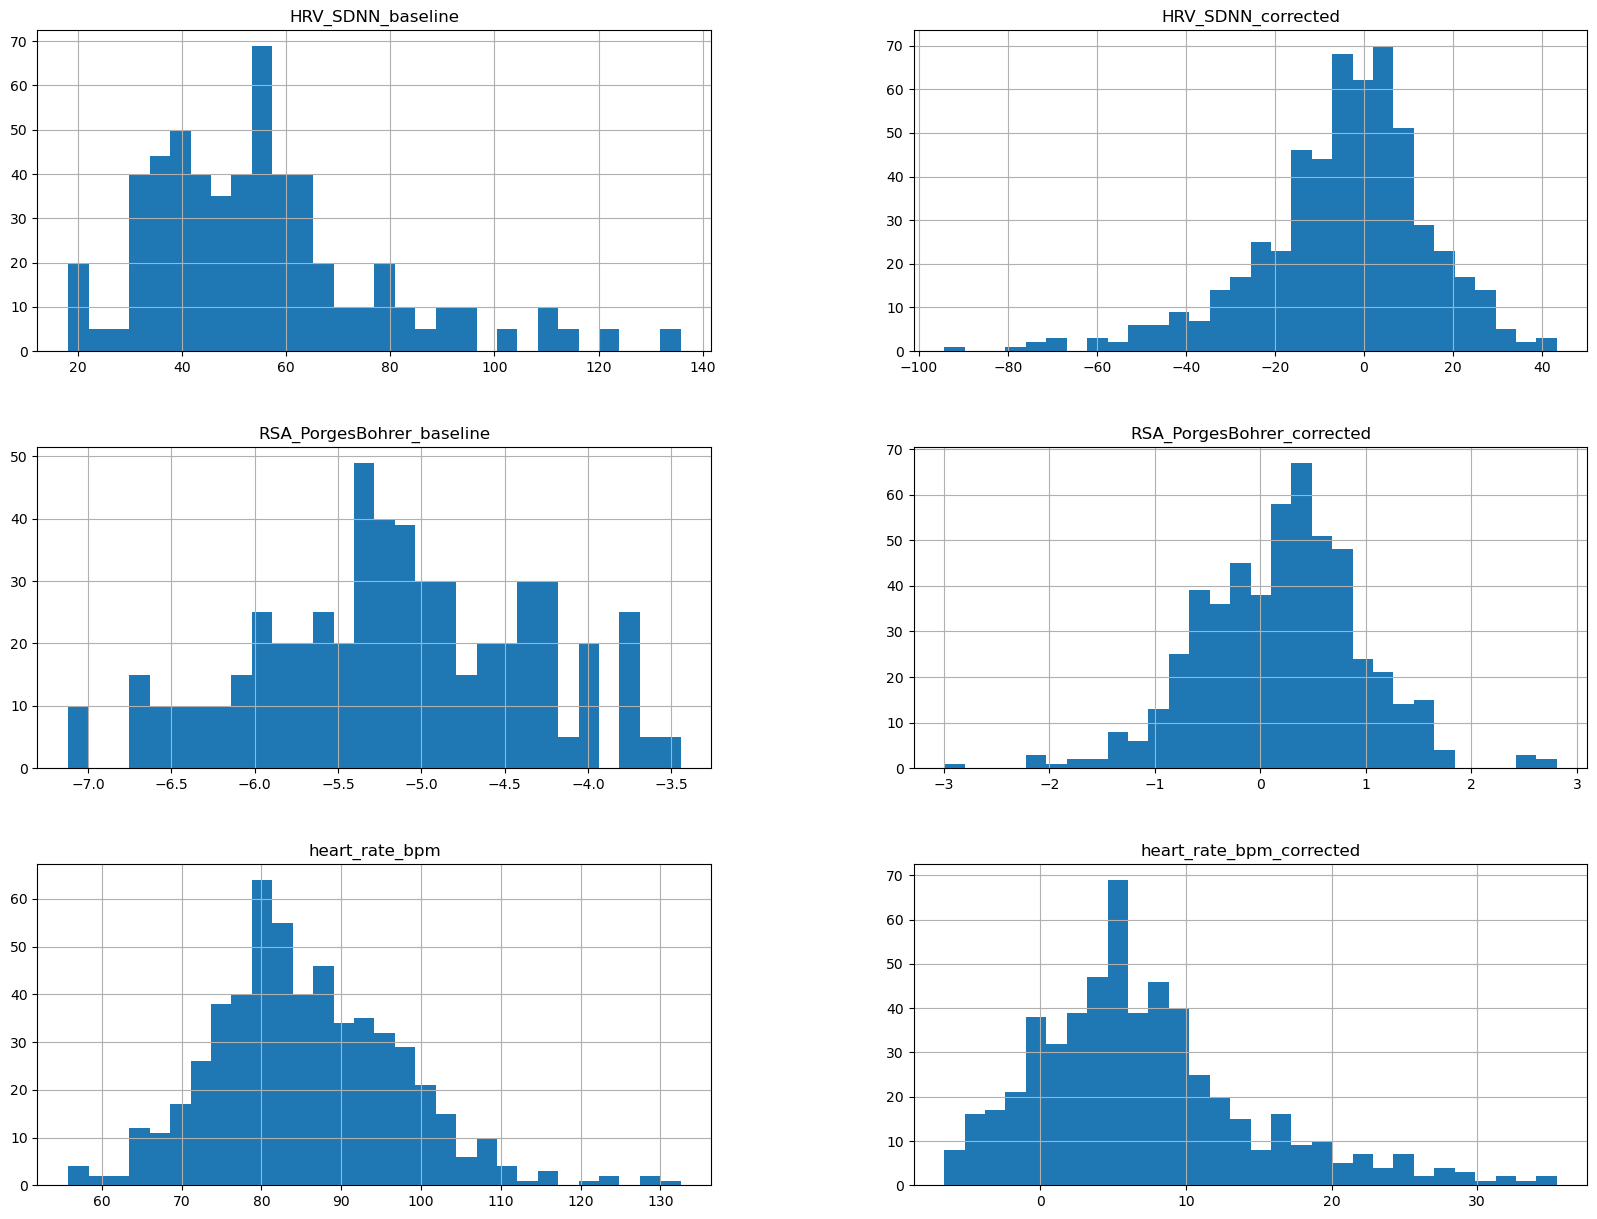

In [19]:
ecg_long_df[["HRV_SDNN_baseline", "HRV_SDNN_corrected", 
        "RSA_PorgesBohrer_baseline", "RSA_PorgesBohrer_corrected",
        "heart_rate_bpm", "heart_rate_bpm_corrected", "segment_name"]].hist(bins=30, figsize=(20, 15))

array([[<Axes: title={'center': 'EDA_Tonic_Mean_baseline'}>,
        <Axes: title={'center': 'EDA_Tonic_Mean_blc'}>],
       [<Axes: title={'center': 'SCR_Peaks_N_per_seconds_baseline'}>,
        <Axes: title={'center': 'SCR_Peaks_N_per_seconds_blc'}>],
       [<Axes: title={'center': 'SCR_Peaks_Amplitude_Mean_baseline'}>,
        <Axes: title={'center': 'SCR_Peaks_Amplitude_Mean_blc'}>]],
      dtype=object)

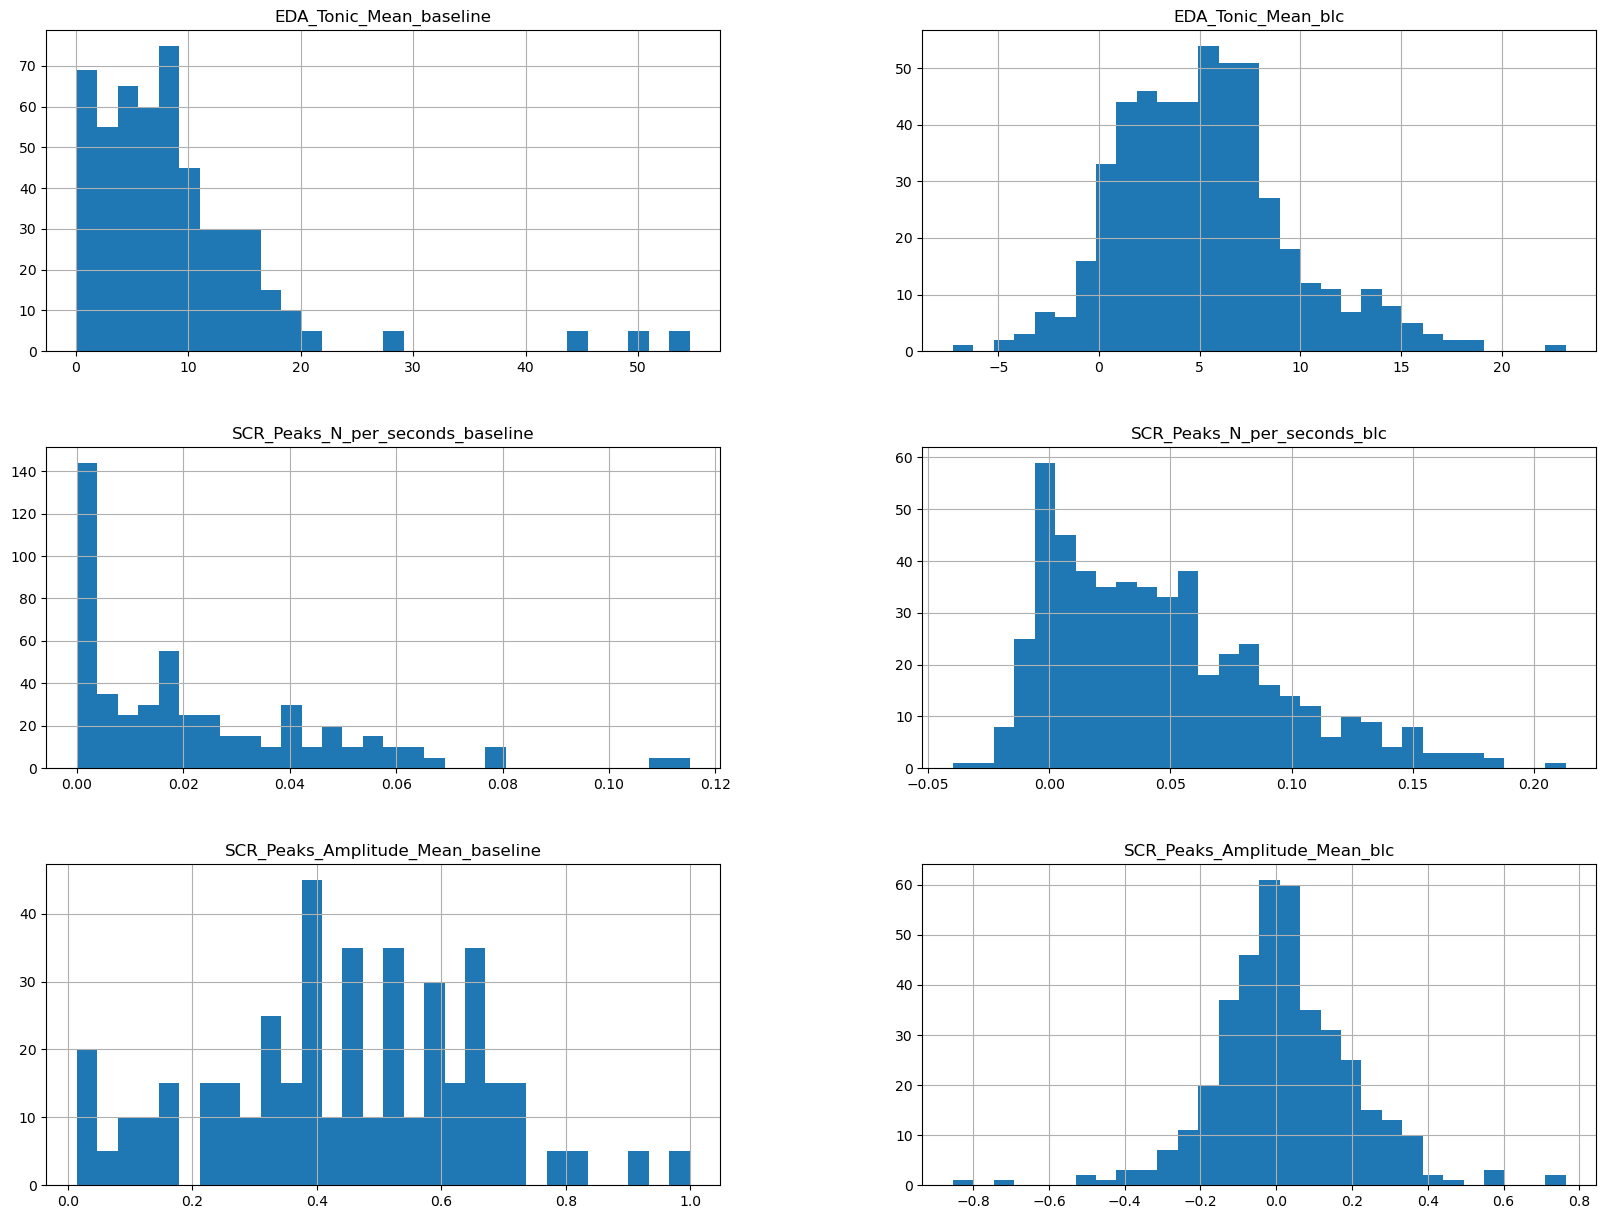

In [20]:
eda_long_df[["EDA_Tonic_Mean_baseline", "EDA_Tonic_Mean_blc", 
        "SCR_Peaks_N_per_seconds_baseline", "SCR_Peaks_N_per_seconds_blc", 
        "SCR_Peaks_Amplitude_Mean_baseline", "SCR_Peaks_Amplitude_Mean_blc", "segment_name"]].hist(bins=30, figsize=(20, 15))

# Export Final dataset

In [22]:
final_df.to_excel(FINAL_DATA_DIR / "neuro-behavioral_data.xlsx", index = False)